## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Initial Data

In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle

# chessboard size to 9x6 for the project
nx = 9
ny = 6
# Choose a larger odd number to smooth gradient measurements

# default folders
input_path = "test_images/"
output_path = 'output_images/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# default parameters for thresholding
s_thr=(120, 255)
x_thr=(40, 100)
s_kernel=15
ksize = 3

print("Initialization done")

Initialization done


## Camera calibration
Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [2]:
# General functions

def grayscale(img):
    '''
    Applies the Grayscale transform
    '''
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def duplicate_image(img):
    '''
    Duplicates an image
    '''
    return np.copy(img)

def calibrate_camera(gray_shape, objpoints, imgpoints):
    '''
    calibrateCamera
    '''
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_shape, None, None)
    return ret, mtx, dist, rvecs, tvecs

def cal_undistort(img, objpoints, imgpoints):
    '''
    takes an image and returns an undistorted image
    '''
    gray = grayscale(img)
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(gray.shape[::-1], objpoints, imgpoints)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def corners_unwarp(img, nx, ny, mtx, dist):
    '''
    takes an image, number of x and y points, camera matrix and distortion coefficients
    '''
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = grayscale(undist)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 # offset for dst points
        img_size = (gray.shape[1], gray.shape[0])
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M
    
def show_image(label, img, time=500):
    '''
    Shows an image
    '''
    cv2.imshow(label,img)
    cv2.waitKey(time)
    plt.imshow(img)

def compare_images(label1, img1, label2, img2):
    '''
    Compare two images
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    #f.tight_layout()
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax1.set_title(label1, fontsize=20)
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax2.set_title(label2, fontsize=20)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def save_image(path, img):
    '''
    Saves an image in the specified folder
    '''
    plt.imsave(path, img)

print("Calibration functions done")

Calibration functions done


## Get Chessboard corners

In [4]:
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('./camera_cal/calibration*.jpg')
img_original = []
img_corners = []

for fname in images:
    img = cv2.imread(fname)
    img_corner = duplicate_image(img)
    gray = grayscale(img_corner)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        img_original.append(img)
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img_corner, (nx,ny), corners, ret)
        img_corners.append(img_corner)
                
gray_shape = gray.shape[::-1]
ret, mtx, dist, rvecs, tvecs = calibrate_camera(gray_shape, objpoints, imgpoints)

# using camera_cal/calibration2.jpg for testing
compare_images('Original', img_original[10], 'Corners', img_corners[10])
path = output_path + 'chessboard2.jpg'
save_image(path, img_corners[0])

print("ChessboardCorners done")

pickle.dump( objpoints, open( "objpoints.p", "wb" ), protocol=0 )
pickle.dump( imgpoints, open( "imgpoints.p", "wb" ), protocol=0 )
print("Serialization done")


ChessboardCorners done
Serialization done


## Calculate Undistortion
Apply a distortion correction to raw images.

In [4]:
dst = cal_undistort(img_original[10], objpoints, imgpoints)

compare_images('Original', img_original[10], 'Undistorted', dst)

path = output_path + 'undistorted1.jpg'
save_image(path, dst)

print("Undistorted chessboard image done")

Undistorted chessboard image done


Undistorted on a sample image done


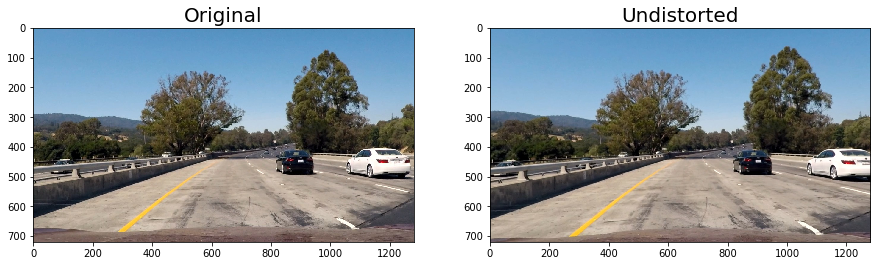

In [5]:
# Use a sample image
sample_image = 'straight_lines1.jpg'
sample_image = 'test2.jpg'
sample_image = 'second_video01.png'
sample_image = 'third_video_1.png'
sample_image = 'third_video_3.png'
sample_image = 'test1.jpg'

sample_path = 'test_images/' + sample_image
img = cv2.imread(sample_path)

dst = cal_undistort(img, objpoints, imgpoints)
compare_images('Original', img, 'Undistorted', dst)

path = output_path + sample_image
save_image(path, dst)

print("Undistorted on a sample image done")

## Color Thresholding
Use color transforms, gradients, etc., to create a thresholded binary image.

Color Thresholding done


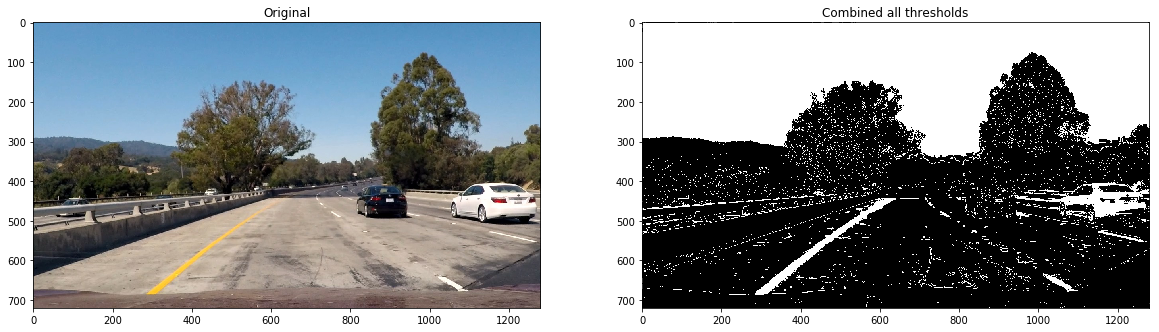

In [6]:
def thresholds(image, 
               s_thresh=(80, 255), # 30, 255 
               sx_thresh=(20, 150), 
               sy_thresh = (20, 255), 
               abs_thresh=(0.9, 1.1), # (0, np.pi/2)
               mag_thresh=(0.9, 1.1), # did not work
               v_thresh=(165,255) # (110,255)
              ): 
    '''
    filter different dhresholds
    '''
    img = duplicate_image(image)    
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1    

    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1        
    
    # Sobel Threshold x gradient
    gray = grayscale(image)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Sobel Threshold y gradient
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobely = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sy_binary = np.zeros_like(scaled_sobel)
    sy_binary[(scaled_sobel >= sy_thresh[0]) & (scaled_sobel <= sy_thresh[1])] = 1    
    
    # Gradient magnitude
    gradmag = np.sqrt(sobelx**2+sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1        
    
    # absolute value of the gradient direction
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= abs_thresh[0]) & (absgraddir <= abs_thresh[1])] = 1    
        
    # Combine a binary image of all thresholds
    combined_binary = np.zeros_like(sx_binary)
    
    ## Pipeline to test separate filters
    #combined_binary[(sy_binary == 1)] = 1
    #combined_binary[(sx_binary == 1)] = 1
    #combined_binary[(sy_binary == 1) & (sx_binary == 1)] = 1
    #combined_binary[(s_binary == 1)] = 1
    #combined_binary[(v_binary == 1)] = 1
    #combined_binary[(v_binary == 1) | (s_binary == 1)] = 1
    #combined_binary[(dir_binary == 1)] = 1
    #combined_binary[((v_binary == 1) | (s_binary == 1)) & (dir_binary == 1)] = 1
    #combined_binary[(s_binary == 1) & (v_binary == 1) | (sx_binary == 1) & (sy_binary == 1)] = 1
    #combined_binary[(s_binary == 1) & (v_binary == 1) | (sx_binary == 1) | (sy_binary == 1)] = 1

    # Working pipelines
    #combined_binary[((s_binary == 1) | (sx_binary == 1)) & ((mag_binary == 1) | (dir_binary == 1))] = 1 # initial
    #combined_binary[((s_binary == 1) | (sx_binary == 1)) & ((v_binary == 1) | (dir_binary == 1))] = 1  # worked fine
    combined_binary[((s_binary == 1) | (sx_binary == 1) | (sy_binary == 1)) & ((v_binary == 1) | (dir_binary == 1))] = 1  # worked fine
    
    return combined_binary

combined_binary = thresholds(img)

#Show result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title('Combined all thresholds')
ax2.imshow(combined_binary, cmap='gray')

path = output_path + 'all_threshold1.jpg'
save_image(path, combined_binary)

print("Color Thresholding done")

## Warped Image
Apply a perspective transform to rectify binary image ("birds-eye view").

Warped image done


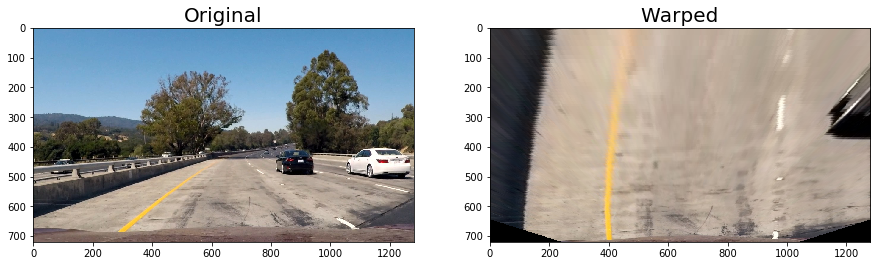

In [7]:
def warper(img, src, dst):
    '''
    Compute and apply perpective transform
    '''
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped

img_warp = duplicate_image(img)
img_size = (img_warp.shape[1], img_warp.shape[0])

'''
# First try
src = np.float32([[190,720], [589,457], [698,457], [1145,720]])
dst = np.float32([[340,720], [340,0], [995,0], [995, 720]])
'''

src = np.float32(
     [[img_size[0] / 2 - 64, img_size[1] / 2 + 100],
      [img_size[0] / 6 - 10, img_size[1]],
      [img_size[0] * 5 / 6 + 10, img_size[1]],
      [img_size[0] / 2 + 64, img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4) + 50, 0],
     [(img_size[0] / 4) + 50, img_size[1]],
     [(img_size[0] * 3 / 4) - 50, img_size[1]],
     [(img_size[0] * 3 / 4) - 50, 0]])
'''
'''

img_undistort = cal_undistort(img_warp, objpoints, imgpoints)
warped = warper(img_undistort, src, dst)

compare_images('Original', img, 'Warped', warped)

path = output_path + 'warped1.jpg'
save_image(path, warped)

print("Warped image done")

## Warp + Threshold image
Use color transforms, gradients, etc., to create a thresholded binary image.

Warped + Threshold image done


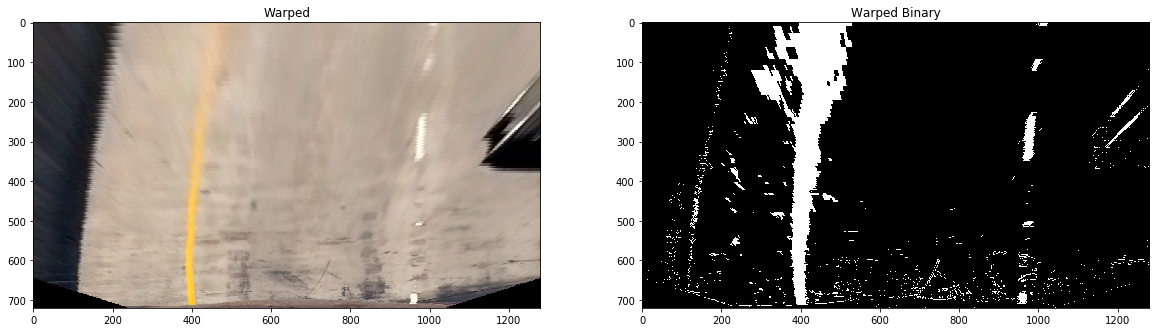

In [8]:
def unwarp(img, src, dst):
    '''
    Unwarps am image
    '''
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR) 
    return warped, M, M_inv

img_undistort = cal_undistort(img_warp, objpoints, imgpoints)
warped = warper(img_undistort, src, dst)
warped_binary = thresholds(warped)

#Show result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Warped')
ax1.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Warped Binary')
ax2.imshow(warped_binary, cmap='gray')

path = output_path + 'warped_threshold1.jpg'
save_image(path, warped_binary)

window_width = 25
window_height = 80

print("Warped + Threshold image done")

## Line detection
Detect lane pixels and fit to find the lane boundary.

In [9]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def detect_line(img):
    '''
    Detect lines from a warped image, basic implementation from the course
    '''
    binary_warped = duplicate_image(img)
    # histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peaks
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    middle_base = np.argmax(histogram[:midpoint]) + midpoint/2
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    correct_distance = rightx_base - leftx_base

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    middle_current = (leftx_base+rightx_base)/2
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty

def show_lanes(img, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    '''
    Show detect lines
    '''
    binary_warped = duplicate_image(img)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])    

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    '''
    # Enable for debugging
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='blue')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    return out_img

print("Line detection functions done")

Line detection functions done


Line detection done


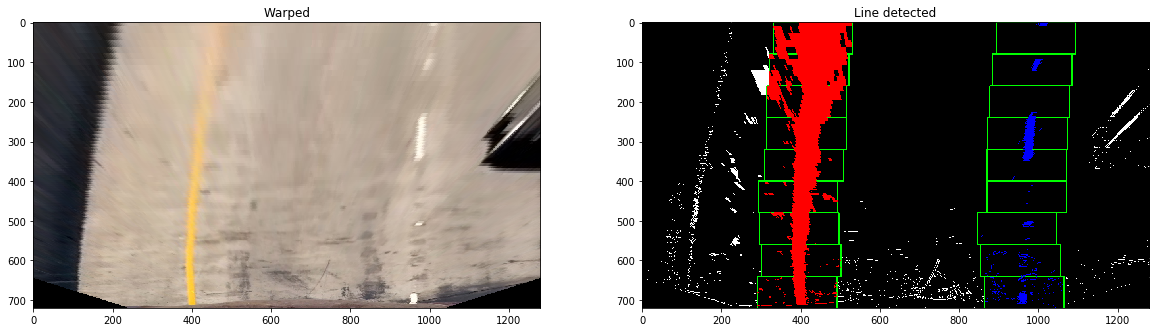

In [10]:
left_fit, right_fit, out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty = detect_line(warped_binary)
image_lane = show_lanes(warped_binary, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds)

#Show result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Warped')
ax1.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Line detected')
ax2.imshow(image_lane)

path = output_path + 'line_detected1.jpg'
save_image(path, image_lane)

print("Line detection done")

## Lane curvature
Determine the curvature of the lane and vehicle position with respect to center.

In [11]:
# Define conversions in x and y from pixels space to meters - US regulations
ym_per_pix = 30.0/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def get_curvature(binary_warped, left_fit, right_fit, leftx, lefty, rightx, righty):
    """"
    Calculate radius of curvature in meters
    https://www.intmath.com/applications-differentiation/8-radius-curvature.php
    """

    y_eval = binary_warped.shape[0] - 1
    
    yvals = range(0,binary_warped.shape[0])
    
    curve_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    # Calculate the new curvature radius
    curveradd = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) / np.absolute(2*curve_fit_cr[0])
    return curveradd

def get_car_offset(binary_warped, curverad, left_fit, right_fit):
    '''
    Calcule the offset of the car on the road
    '''
    yvals = np.arange(0,binary_warped.shape[0])

    left_fitx = np.array(left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2], np.int32)
    right_fitx = np.array(right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2], np.int32)
    
    camera_center = (left_fitx[-1]+right_fitx[-1])/2
    center_diff = (camera_center-binary_warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
            
    return center_diff, side_pos

def add_text_to_image(img, msg, position, color):
    '''
    Add a text to an image
    '''
    result = duplicate_image(img)
    cv2.putText(result, msg, position, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    return result

def get_curvature_message(curv):
    '''
    Wrapper to display curvature message
    '''
    return "Curvature {0:.2f}".format(curv)

def get_position_message(center_diff, side_pos):
    '''
    Wrapper to display position message
    '''
    return "{0:.2f}m to the {1}".format(np.absolute(center_diff), side_pos)

curv = get_curvature(image_lane, left_fit, right_fit, leftx, lefty, rightx, righty)
center_diff, side_pos = get_car_offset(image_lane, curv, left_fit, right_fit)

print(get_curvature_message(curv))
print(get_position_message(center_diff, side_pos))    
    

Curvature 2663.71
0.17m to the left


## Unwarp lane and set Lane boundaries visual display
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [12]:
def compose_image(img1, second_image):
    '''
    Compose two images
    https://docs.opencv.org/3.2.0/d0/d86/tutorial_py_image_arithmetics.html
    '''
    img2 = cv2.resize(second_image, (0,0), fx=0.2, fy=0.2)
    rows, cols, channels = img2.shape
    roi = img1[0:rows, 0:cols ]
    # Now create a mask of thumbnail and create its inverse mask also
    img2gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    # Now black-out the thumbnail in ROI
    img1_bg = cv2.bitwise_and(roi, roi, mask = mask_inv)
    # Take only thumbnail region.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    # Put thumbnail in ROI and modify the main image
    dst = cv2.add(img1_bg,img2_fg)
    img1[0:rows, 0:cols ] = dst
    return img1
    
def apply_lanes(img, image_lane, left_fit, right_fit):
    '''
    Color the detected lane
    '''
    partial_result = duplicate_image(img)

    yvals = np.arange(0, partial_result.shape[0])
    left_fitx = left_fit[0]*yvals*yvals+left_fit[1]*yvals+left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)

    right_fitx = right_fit[0]*yvals*yvals+right_fit[1]*yvals+right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2),axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2),axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2),axis=0), np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

    un_warped, M, Minv = unwarp(image_lane, src, dst)
    
    road_inner = np.zeros_like(un_warped)
    road = np.zeros_like(un_warped)
    
    cv2.fillPoly(road, [left_lane],color=[255,0,0])
    cv2.fillPoly(road_inner, [inner_lane],color=[0,255,0])
    cv2.fillPoly(road, [right_lane],color=[0,0,255])

    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    road_inner_warped = cv2.warpPerspective(road_inner, Minv, img_size, flags=cv2.INTER_LINEAR)

    result = partial_result
    result = cv2.addWeighted(result, 1.0, road_warped, 1., 0.0)
    result = cv2.addWeighted(result, 1.0, road_inner_warped, 0.5, 0.0)
    
    result = compose_image(result, road)    
    return result

result = apply_lanes(img_undistort, image_lane, left_fit, right_fit)
result = add_text_to_image(result, get_curvature_message(curv), (300,50), (255, 255, 255))
result = add_text_to_image(result, get_position_message(center_diff, side_pos), (300,100), (255, 255, 255))

#Show result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title('Complete pipeline')
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

path = output_path + 'complete_pipeline1.jpg'
save_image(path, result)


### Validations
Sanity Check and validations

In [13]:
def sanity_check(binary_warped, left_fit, right_fit, threshold=200):
    '''
    Check if the frame is good
    '''
    is_valid = True
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    correct_distance = rightx_base - leftx_base
    
    # Generate x and y values for comparision in both detected lanes
    ploty = np.linspace(0, binary_warped.shape[0], 20 )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    distance = np.absolute(right_fitx - left_fitx)
    difference = np.absolute(distance - correct_distance)
    if np.max(difference > threshold) == True:
        is_valid = False
    return is_valid, difference

def get_average_line(left_fit, right_fit):
    '''
    Frame is not good, so use an average from previous frames
    '''
    # strategy average current with 10 previous ones and give more weight to the previous ones
    left_fit = np.average(previous_frames, axis=0)[0]*0.7 + left_fit*0.3
    right_fit = np.average(previous_frames, axis=0)[1]*0.7 + right_fit*0.3
    
    '''
    # strategy average current with previous frame
    alpha = 0.5
    global prev_left_fit, prev_right_fit
    if prev_left_fit == None:
        prev_left_fit = left_fit
    else :    
        left_fit = left_fit * ( 1 - alpha) + alpha * prev_left_fit

    if prev_right_fit == None:
        prev_right_fit = right_fit
    else :    
        right_fit = right_fit * ( 1 - alpha) + alpha * prev_right_fit    
    '''
    
    return left_fit, right_fit

print("Validation functions done")

Validation functions done


## All together
Apply the pipeline an all test images

Main pipeline done, check output folder for detail


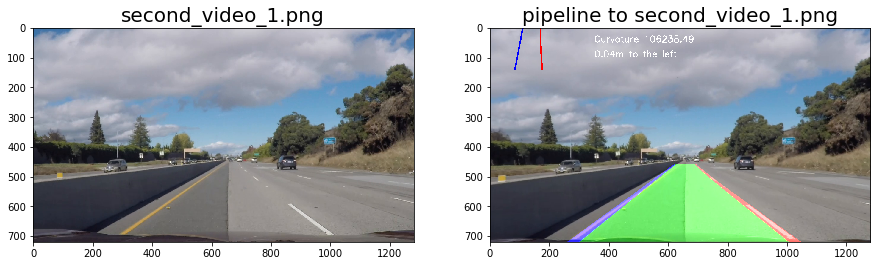

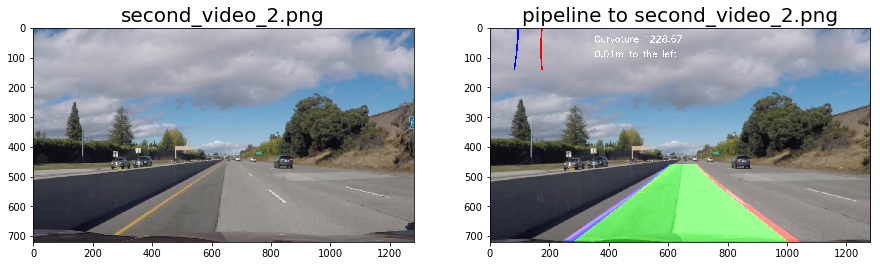

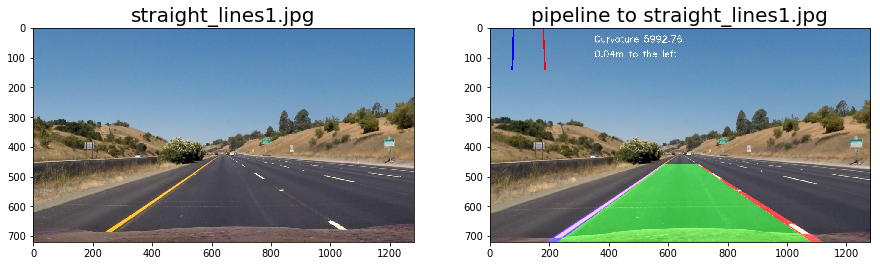

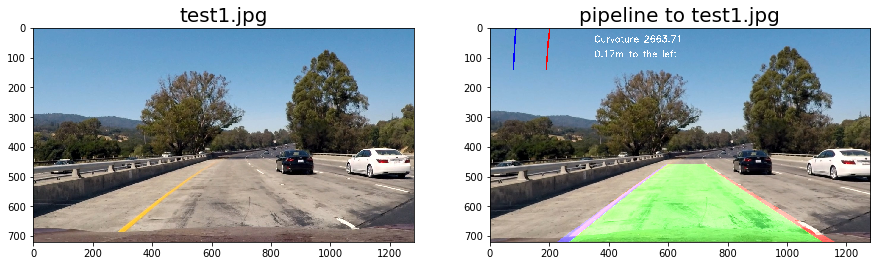

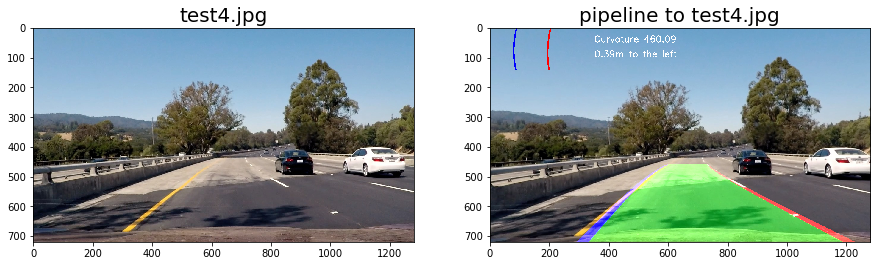

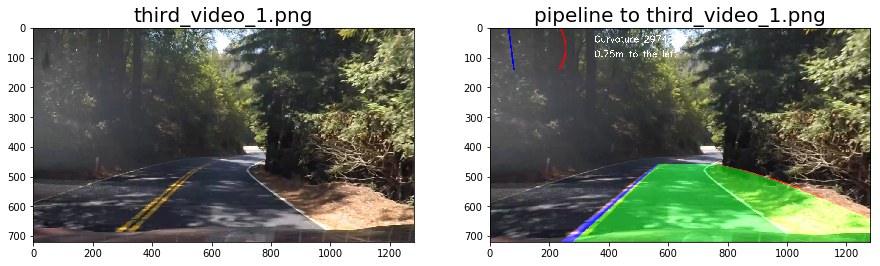

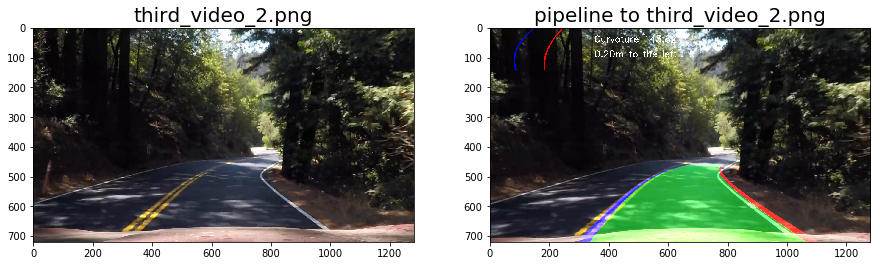

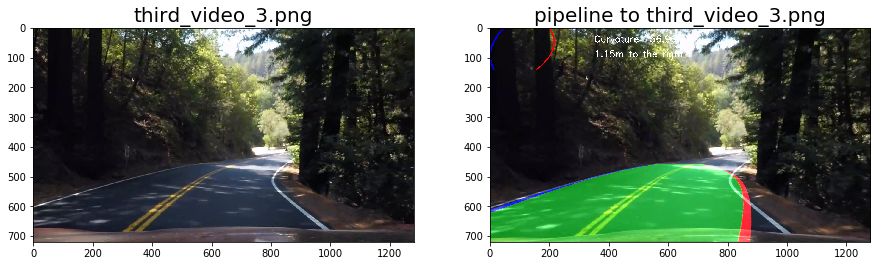

In [14]:
def pipeline(img):
    '''
    Complete image pipeline
    '''
    
    img_undistort = cal_undistort(img, objpoints, imgpoints)
    warped = warper(img_undistort, src, dst)
    warped_binary = thresholds(warped)

    left_fit, right_fit, out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty = detect_line(warped_binary)

    is_valid, dist = sanity_check(warped_binary, left_fit, right_fit)
    if is_valid is False:
        # fallback
        left_fit, right_fit = get_average_line(left_fit, right_fit)
    previous_frames.append((left_fit,right_fit))
    
    image_lane = show_lanes(warped_binary, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds)
        
    curv = get_curvature(image_lane, left_fit, right_fit, leftx, lefty, rightx, righty)
    center_diff, side_pos = get_car_offset(image_lane, curv, left_fit, right_fit)

    result = apply_lanes(img_undistort, image_lane, left_fit, right_fit)
    result = add_text_to_image(result, get_curvature_message(curv), (350,50), (255, 255, 255))
    result = add_text_to_image(result, get_position_message(center_diff, side_pos), (350,100), (255, 255, 255))
    return result

from collections import deque

previous_frames = deque(maxlen=10)
prev_left_fit = 0
prev_right_fit = 0
# Main execution
for item in os.listdir(input_path):
    current_image = cv2.imread(input_path+item)    

    result = pipeline(current_image)
    
    path = "{}pipeline_{}".format(output_path, item)
    save_image(path, result)
    
    compare_images(item, current_image, 'pipeline to {}'.format(item), result)
    #break # To debug just one image

print("Main pipeline done, check output folder for detail")

## Build a Lane Finding Pipeline

Sanity Check: Ok, so your algorithm found some lines. Before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider: 
* Checking that they have similar curvature
* Checking that they are separated by approximately the right distance horizontally
* Checking that they are roughly parallel

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output_path = 'test_videos_output/'
if not os.path.exists(video_output_path):
    os.makedirs(video_output_path)

def generate_video(output_path, video_name, process_image):
    '''
    Generate a video
    '''
    debug = False
    
    output = output_path + video_name

    clip1 = VideoFileClip(video_name)#.subclip(12,13)
    video_clip = clip1.fl_image(process_image)
    %time video_clip.write_videofile(output, audio=False)

    if debug is True:
        extract_frames(clip1, output_path)
    
    clip1.reader.close()
    clip1.audio.reader.close_proc()
    
    return output

def extract_frames(clip, output_path):
    '''
    Extract some images from a video
    '''
    times = 0.1, 0.5, 0.9
    for t in times:
        imgpath = os.path.join(output_path, '{}.png'.format(t))
        clip.save_frame(imgpath, t)

print("Video functions done")

Video functions done


### First Video

In [16]:
first_output = generate_video(video_output_path, 'project_video.mp4', pipeline)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [16:59<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 17min


Inline video

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(first_output))

### Second video

In [18]:
second_output = generate_video(video_output_path, 'challenge_video.mp4', pipeline)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [06:41<00:00,  1.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

Wall time: 6min 42s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(second_output))

### Challenge video

In [20]:
#third_output = generate_video(video_output_path, 'harder_challenge_video.mp4', pipeline)

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(third_output))

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: name 'third_output' is not defined